# Libraries

In [1]:
!pip install tensorflow==2.16.0rc0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 101.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 90.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 107.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.6 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
      Successfully uninstalled tensorboard-2.15.2
  Attempting uninstall: keras
    

In [2]:
!PYTHONHASHSEED=0

In [3]:
import tensorflow as tf
from tensorflow import keras
from matplotlib import pyplot as plt
import zipfile
from shutil import copyfile
from time import time
import numpy as np
import random as python_random
from sklearn.metrics import classification_report, confusion_matrix
import os

In [4]:
np.random.seed(0)
python_random.seed(0)
tf.random.set_seed(0)

# Data loading and preparation

In [6]:
from google.colab import drive
drive.mount('/content/drive')
tar_file_path = '/content/drive/MyDrive/flower_photos.tar'
!tar -xvf {tar_file_path}


Mounted at /content/drive
flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_photos/roses/14019883858_e5d2a0ec10_n.jpg
flower_photos/roses/8035908422_87220425d2_n.jpg
flower_photos/roses/14747962886_2bff6bb323_m.jpg
flower_photos/roses/4356781875_92c5cd93c0.jpg
flower_photos/roses/8524505546_b242bd4928_n.jpg
flower_photos/roses/9406573080_60eab9278e_n.jpg
flower_photos/roses/6039330368_c30ed224c4_m.jpg
flower_photos/roses/14414100710_753a36fce9.jpg
flower_photos/roses/3292434691_392071d702_n.jpg
flower_photos/roses/5273722065_c85d8543c2_m.jpg
flower_photos/roses/2215318403_06eb99176a.jpg
flower_photos/roses/172311368_49412f881b.jpg
flower_photos/roses/15255964454

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

def calculate_mean_shape(dataloader):
    heights = []
    widths = []

    for batch in dataloader:
        images, _ = batch
        # Images are in the format (batch_size, channels, height, width)
        height, width = images.shape[2], images.shape[3]
        heights.append(height)
        widths.append(width)

    mean_height = np.mean(heights)
    mean_width = np.mean(widths)

    return mean_height, mean_width

transform = transforms.Compose([
    transforms.ToTensor()
])

dataset = datasets.ImageFolder('/content/flower_photos', transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

mean_height, mean_width = calculate_mean_shape(dataloader)

print(f"Mean Height: {mean_height}")
print(f"Mean Width: {mean_width}")


Mean Height: 271.79128065395093
Mean Width: 365.0623978201635


The code above perform the mean of height and width of the images to get an accurate size

In [8]:
base_path = '/content/flower_photos'
train_dataset = keras.utils.image_dataset_from_directory(base_path,
                image_size=(271,365),
                batch_size = 32,
                label_mode= "categorical",
                subset = "training",
                validation_split = 0.2,
                shuffle = True,
                seed = 1)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
base_path = '/content/flower_photos'
validation_dataset = keras.utils.image_dataset_from_directory(base_path,
                image_size=(271,365),
                batch_size = 32,
                label_mode= "categorical",
                subset = "validation",
                validation_split = 0.2,
                shuffle = True,
                seed = 1)


Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Before training a neural network, tipically the dataset is splitted in two parts:


*   Training: set of observations, around the 70%-80% of the entire dataset, used to train the neural network;
*   Validation: set of observations, around the 20%-30%, used to evaluate the model.

We set TRUE on shuffle to pick randomly the observations. In particular on the validation set we must set TRUE beacuse the observations are listed so if we set FALSE we'll get only 1 or 2 type of flowers



# Model from scratch

## Simple model

We start from a simple architecture to see the trend and then we'll adjust it to reach better results

In [10]:
num_classes = 5

In [11]:
inputs = keras.Input((271,365,3))
x = inputs
x = keras.layers.Conv2D(32,3, padding = "same")(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same")(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
net_simple = keras.Model(inputs, outputs)

In [12]:
net_simple.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 271, 365, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 271, 365, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 271, 365, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 91, 122, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 91, 122, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 91, 122, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d                 │ (None, 64)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,717 (77.02 KB)

 Trainable params: 19,717 (77.02 KB)

 Non-trainable params: 0 (0.00 B)

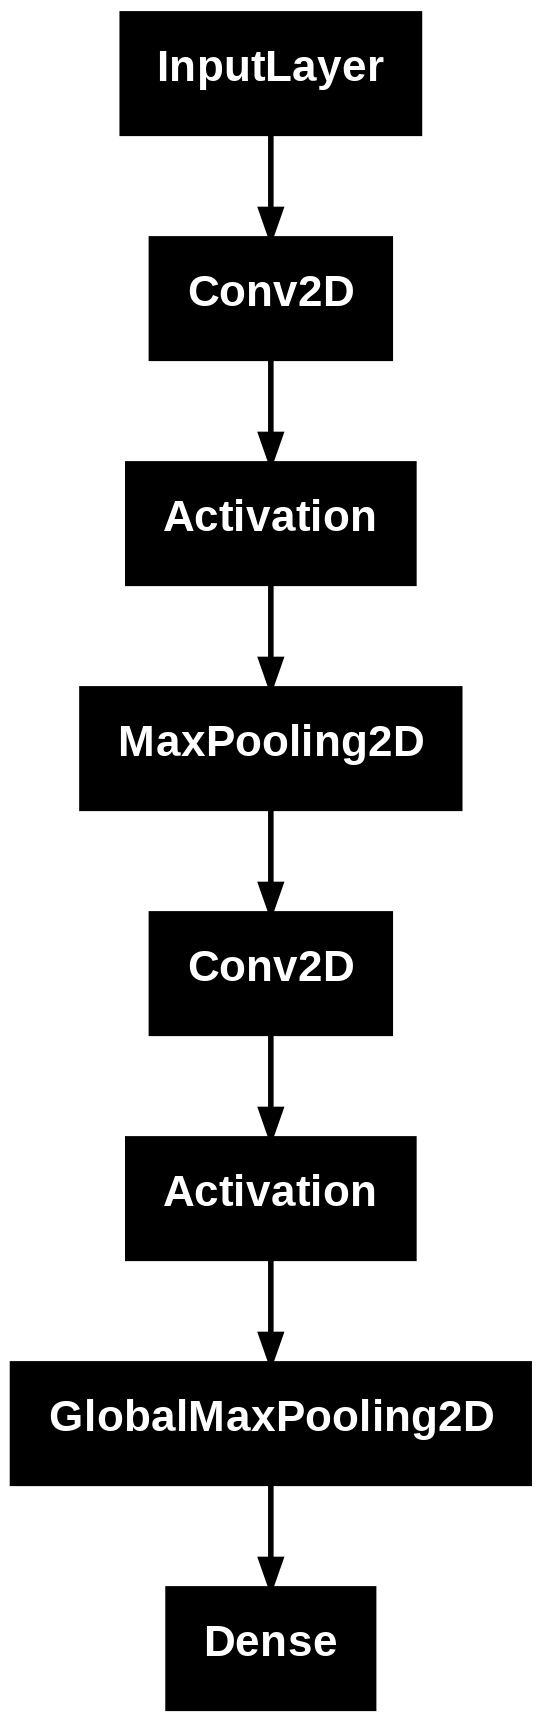

In [13]:
keras.utils.plot_model(net_simple, to_file='model.png')

In [14]:
net_simple.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
            metrics=['accuracy'])

On this part we configure the model for training:


*   loss: loss function that will be minimized
*   optimizer: algorithm that changes the attributes of model to reduce the loss function based on the learning rate, that is the width of the steps
*   metrics: used to judge the model performance, in this case by the accuracy





In [15]:
history = net_simple.fit(train_dataset,
          epochs=40,
          validation_data=validation_dataset);

Epoch 1/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 34s 304ms/step - accuracy: 0.3435 - loss: 18.3113 - val_accuracy: 0.5341 - val_loss: 2.2430
Epoch 2/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - accuracy: 0.5010 - loss: 2.6279 - val_accuracy: 0.5218 - val_loss: 1.9592
Epoch 3/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.5479 - loss: 1.6695 - val_accuracy: 0.5218 - val_loss: 1.6548
Epoch 4/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 108ms/step - accuracy: 0.5954 - loss: 1.2506 - val_accuracy: 0.5341 - val_loss: 1.6216
Epoch 5/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 115ms/step - accuracy: 0.6462 - loss: 0.9829 - val_accuracy: 0.6144 - val_loss: 1.1551
Epoch 6/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.7010 - loss: 0.8469 - val_accuracy: 0.5272 - val_loss: 1.4869
Epoch 7/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - accuracy: 0.7115 - loss: 0.7633 - val_accuracy: 0.6076 - val_loss: 1.1898
Epoch 8/40
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7318 - loss: 0.7237 - val_accuracy

### Evaluation

In [16]:
loss, accuracy = net_simple.evaluate(validation_dataset)


print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - accuracy: 0.6911 - loss: 1.7131
Validation Loss: 1.6443219184875488
Validation Accuracy: 0.7111716866493225


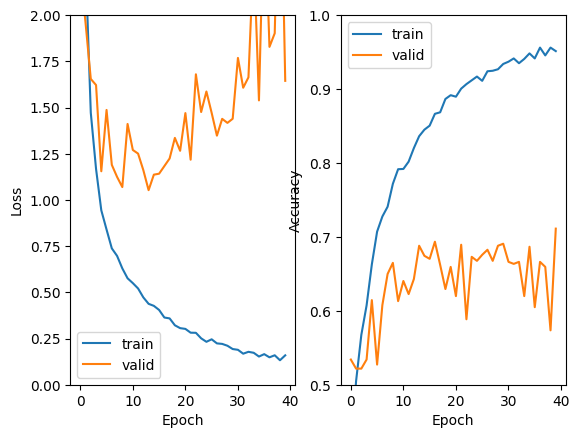

In [17]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

We can see that the training can reach good results but the validation is too low, the history abd the plots shows that the model is in overfitting

### Inference

In [18]:
yc_test = np.concatenate([y for _, y in validation_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)
yc_pred = net_simple.predict(validation_dataset)
y_pred = np.argmax(yc_pred, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step


In [19]:
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.16      0.15      0.15       125
           1       0.25      0.26      0.26       197
           2       0.15      0.16      0.15       107
           3       0.19      0.20      0.19       138
           4       0.20      0.17      0.19       167

    accuracy                           0.20       734
   macro avg       0.19      0.19      0.19       734
weighted avg       0.20      0.20      0.20       734



On the classification report we can see some useful information, but in this case follows the trend of the history with bad results.

Confusion matrix:


Text(0, 0.5, 'Ground truth class')

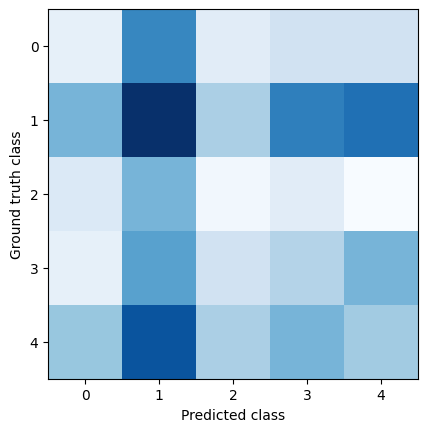

In [20]:
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

This confsuion matrix is not very useful

## Enhanced Model

In this model, based on the first one, we'll add regularization and batch normalization to avoid overfitting

In [21]:
inputs = keras.Input((271,365,3))
x = inputs
x = keras.layers.Conv2D(32,3, padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding="same", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
net_enh = keras.Model(inputs, outputs)

In [22]:
net_enh.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 271, 365, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 271, 365, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 271, 365, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 271, 365, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 91, 122, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 91, 122, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 91, 122, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_1               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,845 (77.52 KB)

 Trainable params: 19,781 (77.27 KB)

 Non-trainable params: 64 (256.00 B)

In [23]:
net_enh.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.0001), # lower learning rate to have more stability
            metrics=['accuracy'])

We add also a callback to monitor the value of the loss function to avoid the model overfit and stop early

In [24]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [25]:
history = net_enh.fit(train_dataset,
          epochs=50,
          validation_data=validation_dataset,
            callbacks=[callback]);

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.2334 - loss: 6.3903 - val_accuracy: 0.4360 - val_loss: 5.6328
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 119ms/step - accuracy: 0.4645 - loss: 5.4273 - val_accuracy: 0.5204 - val_loss: 4.9199
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step - accuracy: 0.5786 - loss: 4.7627 - val_accuracy: 0.5872 - val_loss: 4.3775
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 84ms/step - accuracy: 0.5978 - loss: 4.2383 - val_accuracy: 0.6240 - val_loss: 3.9449
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.6266 - loss: 3.7952 - val_accuracy: 0.6512 - val_loss: 3.5392
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 93ms/step - accuracy: 0.6538 - loss: 3.4215 - val_accuracy: 0.6526 - val_loss: 3.2050
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.6678 - loss: 3.1006 - val_accuracy: 0.6689 - val_loss: 2.9369
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 119ms/step - accuracy: 0.6734 - loss: 2.8389 - val_accuracy

### Evaluation

In [26]:
loss, accuracy = net_enh.evaluate(validation_dataset)


print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.7512 - loss: 1.0398
Validation Loss: 1.0074268579483032
Validation Accuracy: 0.7588555812835693


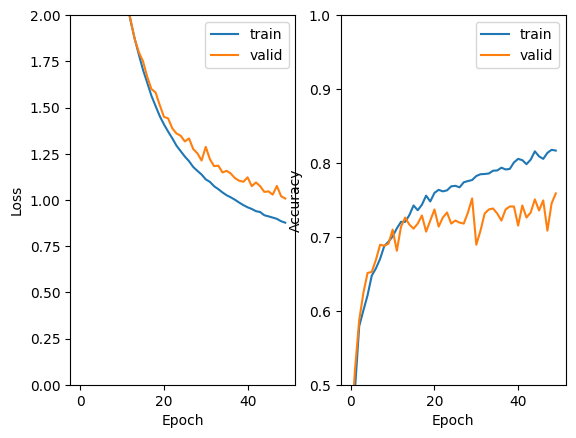

In [27]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

The results is slightly better in terms of overift and validation accuracy than before and regularizating it we loss some accuracy on the training

### Inference

In [28]:
yc_test = np.concatenate([y for _, y in validation_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)
yc_pred = net_enh.predict(validation_dataset)
y_pred = np.argmax(yc_pred, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


In [29]:
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.18      0.16      0.17       125
           1       0.27      0.29      0.28       197
           2       0.18      0.19      0.18       107
           3       0.16      0.16      0.16       138
           4       0.27      0.26      0.26       167

    accuracy                           0.22       734
   macro avg       0.21      0.21      0.21       734
weighted avg       0.22      0.22      0.22       734



Confusion matrix:


Text(0, 0.5, 'Ground truth class')

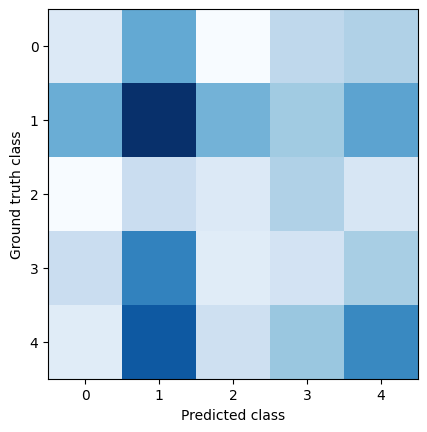

In [30]:
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

Also in this case the results of the inference are not very useful

## Enhanced model 2

Seeing the results before, we decide to construct a deeper model in order to try to gain the maximum that our observations can give

In [31]:
inputs = keras.Input((271,365,3))
x = inputs

x = keras.layers.Conv2D(16,3, padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32,3, padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.Conv2D(64,3, padding = "same", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.Activation("relu")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

outputs = keras.layers.Dense(num_classes, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
net_deep = keras.Model(inputs, outputs)

In [32]:
net_deep.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 271, 365, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 271, 365, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 271, 365, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_4 (Activation)            │ (None, 271, 365, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 91, 122, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 91, 122, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 91, 122, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_5 (Activation)            │ (None, 91, 122, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 91, 122, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 91, 122, 64)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling2d_2               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling2D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,101 (94.14 KB)

 Trainable params: 24,005 (93.77 KB)

 Non-trainable params: 96 (384.00 B)

In [33]:
net_deep.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
            metrics=['accuracy'])

In [34]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [35]:
history = net_deep.fit(train_dataset,
          epochs=50,
          validation_data=validation_dataset,
            callbacks=[callback]);

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 145ms/step - accuracy: 0.2814 - loss: 9.9388 - val_accuracy: 0.3161 - val_loss: 8.5922
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - accuracy: 0.4654 - loss: 8.1802 - val_accuracy: 0.5463 - val_loss: 7.4829
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - accuracy: 0.5712 - loss: 7.2171 - val_accuracy: 0.6049 - val_loss: 6.6400
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 95ms/step - accuracy: 0.6283 - loss: 6.4357 - val_accuracy: 0.6308 - val_loss: 5.9674
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.6366 - loss: 5.7996 - val_accuracy: 0.6308 - val_loss: 5.3976
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - accuracy: 0.6699 - loss: 5.2495 - val_accuracy: 0.6376 - val_loss: 4.9184
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - accuracy: 0.6816 - loss: 4.7659 - val_accuracy: 0.6471 - val_loss: 4.5004
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.6907 - loss: 4.3699 - val_accuracy: 0.666

### Evaluation

In [36]:
loss, accuracy = net_deep.evaluate(validation_dataset)


print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.7166 - loss: 1.3402
Validation Loss: 1.3249980211257935
Validation Accuracy: 0.7220708727836609


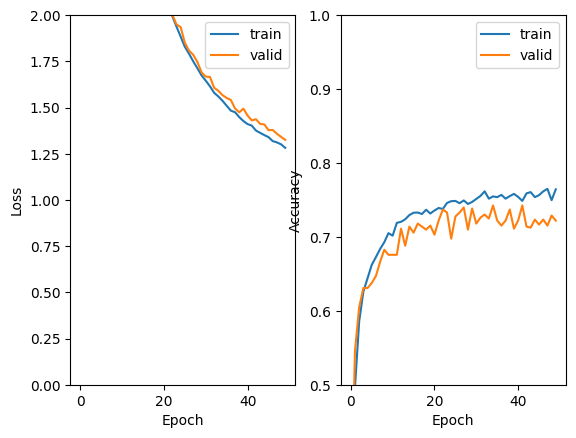

In [37]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 2.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.5, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

The results is that we loss another portion of training accuracy, maybe we have few observations so we'll try with data augmentation

### Inference

In [38]:
yc_test = np.concatenate([y for _, y in validation_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)
yc_pred = net_deep.predict(validation_dataset)
y_pred = np.argmax(yc_pred, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step


In [39]:
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.20      0.17      0.18       125
           1       0.26      0.28      0.27       197
           2       0.18      0.16      0.17       107
           3       0.14      0.16      0.15       138
           4       0.23      0.23      0.23       167

    accuracy                           0.21       734
   macro avg       0.20      0.20      0.20       734
weighted avg       0.21      0.21      0.21       734



Confusion matrix:


Text(0, 0.5, 'Ground truth class')

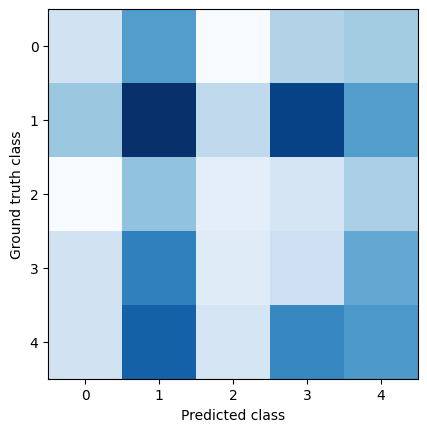

In [40]:
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

# Model with Data Augmentation

In [41]:
train_aug = keras.preprocessing.image_dataset_from_directory(base_path,
                                                            image_size=(290,390),
                                                            batch_size=32,
                                                            label_mode='categorical',
                                                            subset = "training",
                                                            validation_split = 0.2,
                                                            shuffle=True,
                                                            seed=1)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


To compute the data augmentation we have to set larger size to the image due to RandomCrop layer

In [42]:
inputs = keras.Input((None,None,3))

x = inputs

x = keras.layers.RandomCrop(271, 365)(x)
x = keras.layers.RandomFlip(mode='horizontal')(x)
x = keras.layers.RandomContrast(0.1)(x)

x = keras.layers.Conv2D(16, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('selu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(32, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('selu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('selu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.Conv2D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation('selu')(x)
x = keras.layers.MaxPooling2D(3, strides=3, padding="same")(x)

x = keras.layers.GlobalMaxPooling2D()(x)

x = keras.layers.Dense(64, activation="selu", kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)

outputs = keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))(x)
net_aug = keras.Model(inputs, outputs)

In [43]:
net_aug.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_crop (RandomCrop)             │ (None, 271, 365, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_flip (RandomFlip)             │ (None, 271, 365, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_contrast (RandomContrast)     │ (None, 271, 365, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 271, 365, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 271, 365, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 271, 365, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 91, 122, 16)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 91, 122, 32)         │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 91, 122, 32)         │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_8 (Activation)            │ (None, 91, 122, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 31, 41, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 31, 41, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 31, 41, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_9 (Activation)            │ (None, 31, 41, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 11, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 11, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 11, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_10 (Activation)           │ (None, 11, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 65,701 (256.64 KB)

 Trainable params: 65,349 (255.27 KB)

 Non-trainable params: 352 (1.38 KB)

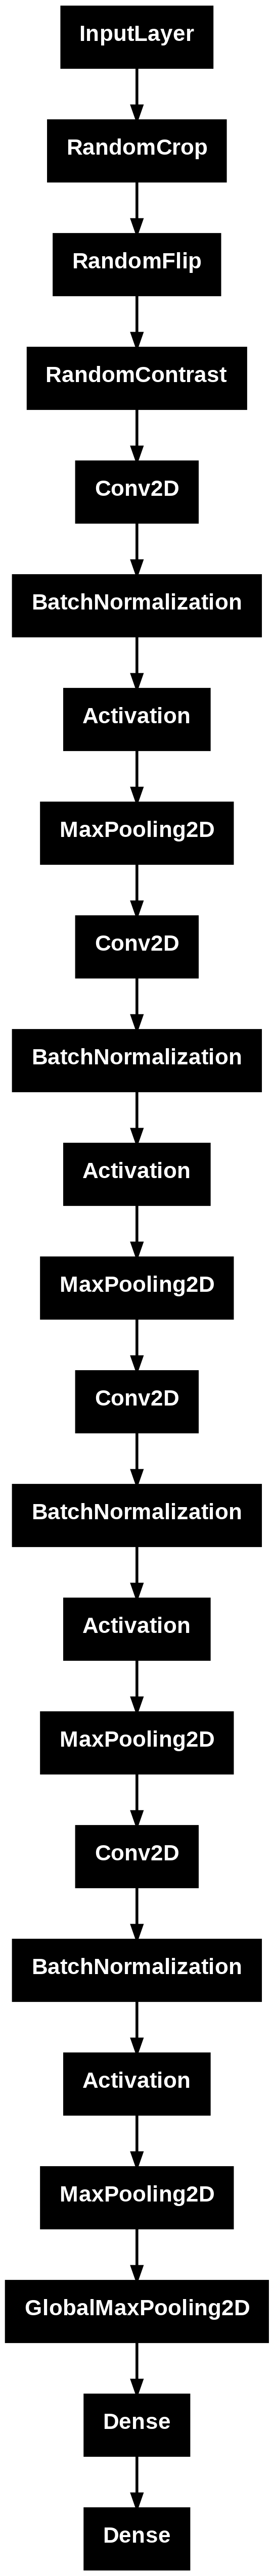

In [44]:
keras.utils.plot_model(net_aug, to_file='model.png')

In [45]:
net_aug.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=keras.optimizers.RMSprop(learning_rate=0.0001),
            metrics=['accuracy'])

In [46]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [47]:
history = net_aug.fit(train_aug,
          epochs=50,
          validation_data=validation_dataset,
            callbacks=[callback]);

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 22s 141ms/step - accuracy: 0.3505 - loss: 21.5130 - val_accuracy: 0.4128 - val_loss: 19.7968
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 118ms/step - accuracy: 0.5945 - loss: 19.0229 - val_accuracy: 0.6076 - val_loss: 17.6148
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.6461 - loss: 17.1167 - val_accuracy: 0.6635 - val_loss: 15.8085
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.6718 - loss: 15.3991 - val_accuracy: 0.6907 - val_loss: 14.2828
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 186ms/step - accuracy: 0.6925 - loss: 13.9078 - val_accuracy: 0.7098 - val_loss: 12.9079
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 142ms/step - accuracy: 0.7196 - loss: 12.5586 - val_accuracy: 0.7221 - val_loss: 11.7465
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 165ms/step - accuracy: 0.7299 - loss: 11.4287 - val_accuracy: 0.7384 - val_loss: 10.7107
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.7436 - loss: 10.

## Evaluation

In [48]:
loss, accuracy = net_aug.evaluate(validation_dataset)


print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.8226 - loss: 1.2772
Validation Loss: 1.2455755472183228
Validation Accuracy: 0.8378746509552002


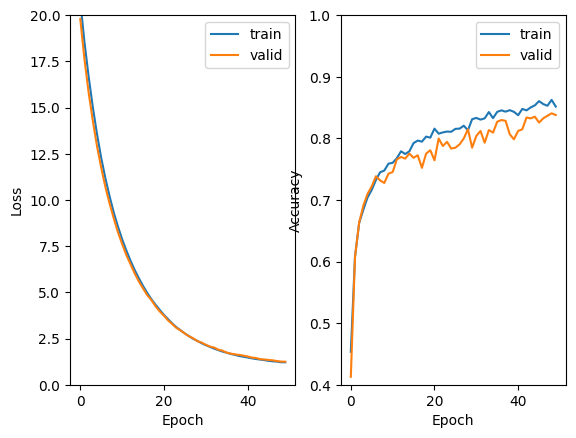

In [49]:
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim([0.0, 20.0])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'valid'])

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim([0.4, 1.0])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['train', 'valid'])

With the data augmentation we reach great results. We build a more complex model, in particular using a deep pooling to retain the most important features. The most important change was that to swap the activation function from "relu" to "selu", because the first suffer of the typical vanishing gradiant instead of the second that has a self-normalizing property, this lead the model to stabilizie the training process and to a faster convergence

## Inference

In [50]:
yc_test = np.concatenate([y for _, y in validation_dataset], axis=0)
y_test = np.argmax(yc_test, axis=1)
yc_pred = net_aug.predict(validation_dataset)
y_pred = np.argmax(yc_pred, axis=1)

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step


In [51]:
print('Classification report:')
print(classification_report(y_test, y_pred))

Classification report:
              precision    recall  f1-score   support

           0       0.19      0.17      0.18       125
           1       0.27      0.27      0.27       197
           2       0.12      0.14      0.13       107
           3       0.18      0.20      0.19       138
           4       0.30      0.27      0.28       167

    accuracy                           0.22       734
   macro avg       0.21      0.21      0.21       734
weighted avg       0.22      0.22      0.22       734



Confusion matrix:


Text(0, 0.5, 'Ground truth class')

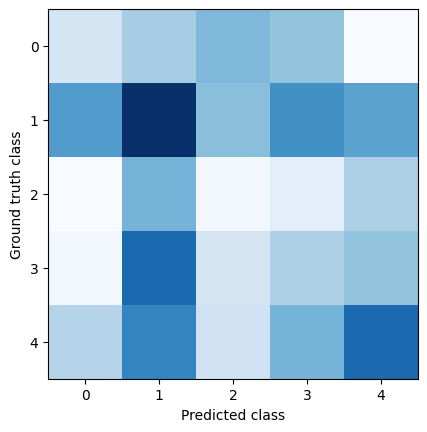

In [52]:
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xlabel('Predicted class')
plt.ylabel('Ground truth class')

As we see in the other model the inference step doesn't have much sense, maybe the model can't generelize due to the deep pooling or it needs more data to generalize better.

# Model saving

In [54]:
net_aug.save('/content/gdrive/My Drive/my_model.keras')